In [103]:
import numpy as np
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

from alibi_detect.od import SpectralResidual

import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})

In [104]:
data_path = '../../../../data/train_data/host'
dfs = {}
for file in os.listdir(data_path):
    print('Reading ' + file)
    dfs[file[:-4]] = pd.read_csv(data_path+'/'+file) 

Reading dcos_docker.csv
Reading os_linux.csv
Reading db_oracle_11g.csv
Reading mw_redis.csv
Reading dcos_container.csv


In [105]:
def gen_train_seq(values):
    time_steps = 10

    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    
    return np.stack(output)

In [106]:
for key in dfs:
    print('*'*40)
    print(key)
    df = dfs[key]
    for name in list(df.name.unique()):
        df_n = df[df.name==name]
        for cmdb_id in list(df_n.cmdb_id.unique()):
            df_nc = df_n[df_n.cmdb_id == cmdb_id]
            df_nc = df_nc.set_index('timestamp')['value']
        if np.mean(df_nc) != 0:
            df_sample = df_nc
            break

****************************************
dcos_docker
****************************************
os_linux
****************************************
db_oracle_11g
****************************************
mw_redis
****************************************
dcos_container


In [194]:
print(dfs['dcos_docker']['cmdb_id'].unique())
print(dfs['dcos_docker']['name'].unique())

['docker_008' 'docker_003' 'docker_002' 'docker_005' 'docker_004'
 'docker_007' 'docker_001' 'docker_006']
['container_session_used' 'container_fgct' 'container_cpu_used'
 'container_thread_idle' 'container_thread_running'
 'container_thread_total' 'container_fgc' 'container_thread_used_pct'
 'container_mem_used']


<ipython-input-213-5c54595d00e5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']
No threshold level set. Need to infer threshold using `infer_threshold`.


1.470415252524233


<AxesSubplot:>

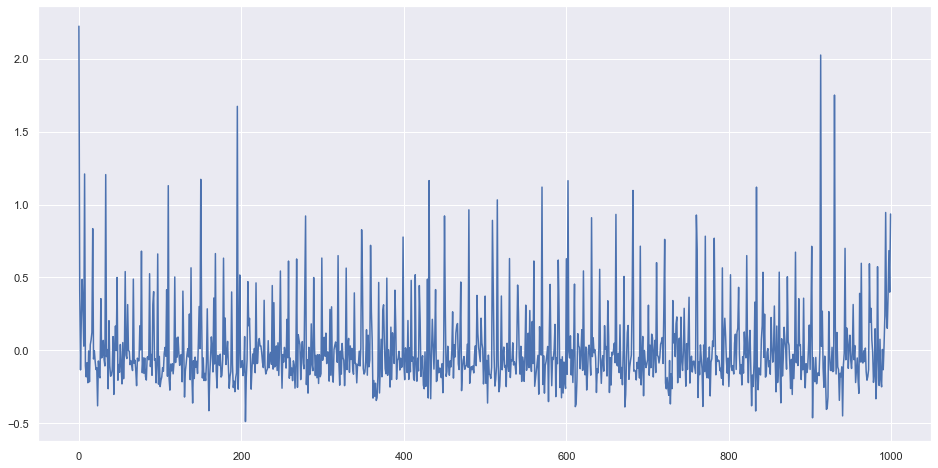

In [213]:
df = dfs['os_linux']
df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']

# df = dfs['dcos_docker']
# df = df[df.name == 'container_cpu_used'][df.cmdb_id=='docker_003']

od = SpectralResidual(
    window_amp=20,
    window_local=20,
    n_est_points=1,
    n_grad_points=1
)

od.infer_threshold(df['value'].values, threshold_perc=99.9)
print(od.threshold)

window_size = 1000
inst_s = od.predict(df['value'].values[:window_size],return_instance_score=True)['data']['instance_score']
# sns.lineplot(x=range(len(df[:window_size].values)), y='value',data=df[:window_size])
sns.lineplot(x=range(len(inst_s)), y=inst_s)


<AxesSubplot:>

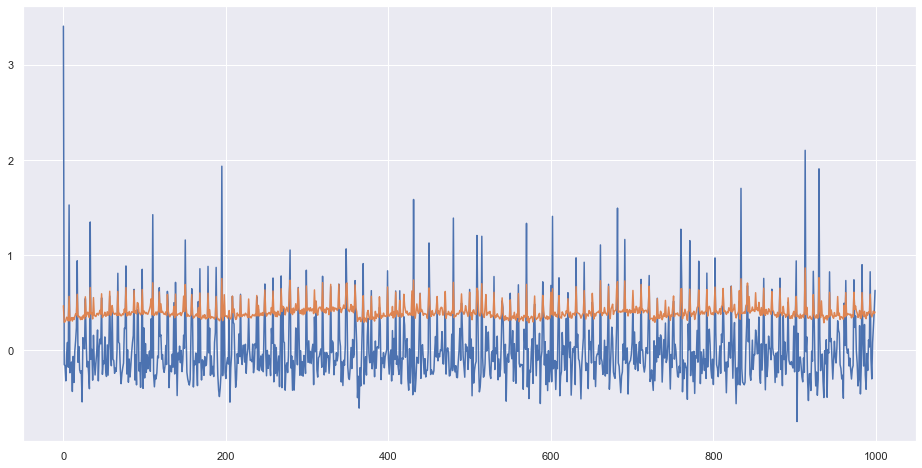

<ipython-input-181-d39ce934a421>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']


<AxesSubplot:xlabel='timestamp', ylabel='value'>

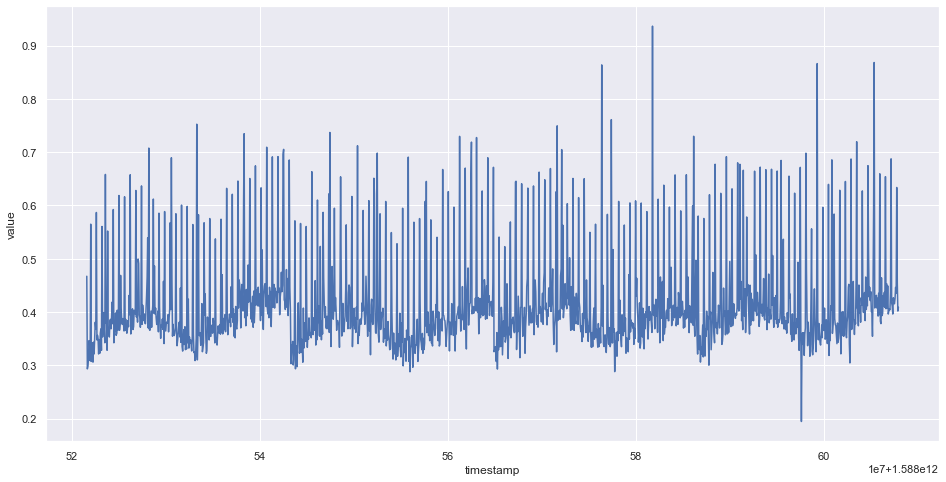

In [181]:
df = dfs['os_linux']
df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']
sns.lineplot(y='value',x='timestamp',data=df)